In [1]:
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [2]:
model_type = "mms-1b-all"
model_name = f"facebook/{model_type}"
repo_name = f"{model_type}-bengali"
num_val_samples = 1024 * 16

In [3]:
from huggingface_hub import notebook_login

notebook_login()

In [4]:
target_lang = "ben"

# Load Processor

In [5]:
from transformers import Wav2Vec2CTCTokenizer

mms_adapter_repo = "facebook/mms-1b-all"  # make sure to replace this path with a repo to which you want to add your new adapter weights

tokenizer = Wav2Vec2CTCTokenizer.from_pretrained(model_name)

In [6]:
# tokenizer.push_to_hub(repo_name)

In [7]:
from transformers import Wav2Vec2FeatureExtractor

feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=True)


In [8]:
from transformers import Wav2Vec2Processor

processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)
processor.tokenizer.set_target_lang(target_lang)


# Dataset
## Kaggle Dataset

In [9]:
from datasets import DatasetDict, Audio

bengali_dataset = DatasetDict.load_from_disk("/data/abdalla/bengaliai-speech_huggingface")

In [10]:
def prepare_dataset(batch):
    audio = batch["audio"]

    # batched output is "un-batched"
    batch["input_values"] = processor(audio["array"], sampling_rate=16_000).input_values[0]
    batch["input_length"] = len(batch["input_values"])

    batch["labels"] = processor(text=batch["sentence"]).input_ids
    return batch

In [11]:
bengali_dataset["train"] = bengali_dataset["train"].map(prepare_dataset, remove_columns=bengali_dataset["train"].column_names, num_proc=128)

In [12]:
bengali_dataset["validation"] = bengali_dataset["validation"].map(prepare_dataset, remove_columns=bengali_dataset["validation"].column_names, num_proc=32)

## Mozilla Common Voice Dataset

In [13]:
from datasets import load_dataset, load_metric, Audio

common_voice_train = load_dataset("mozilla-foundation/common_voice_13_0", "bn", split="train", download_mode="force_redownload", use_auth_token=True)
common_voice_val = load_dataset("mozilla-foundation/common_voice_13_0", "bn", split="test", download_mode="force_redownload", use_auth_token=True)

/opt/conda/lib/python3.10/site-packages/datasets/load.py:2069: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=True' instead.
  warnings.warn(


In [ ]:
common_voice_train = common_voice_train.remove_columns(["accent", "age", "client_id", "down_votes", "gender", "locale", "segment", "up_votes", "path", "variant"])
common_voice_val = common_voice_val.remove_columns(["accent", "age", "client_id", "down_votes", "gender", "locale", "segment", "up_votes", "path", "variant"])

In [ ]:
common_voice_train = common_voice_train.cast_column("audio", Audio(sampling_rate=16_000))
common_voice_val = common_voice_val.cast_column("audio", Audio(sampling_rate=16_000))

In [ ]:
common_voice_train = common_voice_train.map(prepare_dataset, remove_columns=common_voice_train.column_names)
common_voice_val = common_voice_val.map(prepare_dataset, remove_columns=common_voice_val.column_names)

Loading cached processed dataset at /home/dev/.cache/huggingface/datasets/mozilla-foundation___common_voice_13_0/bn/13.0.0/2506e9a8950f5807ceae08c2920e814222909fd7f477b74f5d225802e9f04055/cache-691f3a9e33d108b9.arrow
Loading cached processed dataset at /home/dev/.cache/huggingface/datasets/mozilla-foundation___common_voice_13_0/bn/13.0.0/2506e9a8950f5807ceae08c2920e814222909fd7f477b74f5d225802e9f04055/cache-1fbfd44b063357b5.arrow


In [ ]:
from datasets import concatenate_datasets

combined_train = concatenate_datasets([bengali_dataset["train"], common_voice_train])

In [ ]:
combined_val = concatenate_datasets([bengali_dataset["validation"], common_voice_val])

In [ ]:
dataset = DatasetDict({"train": combined_train, "validation": combined_val})

array([[<Axes: title={'center': '0'}>]], dtype=object)

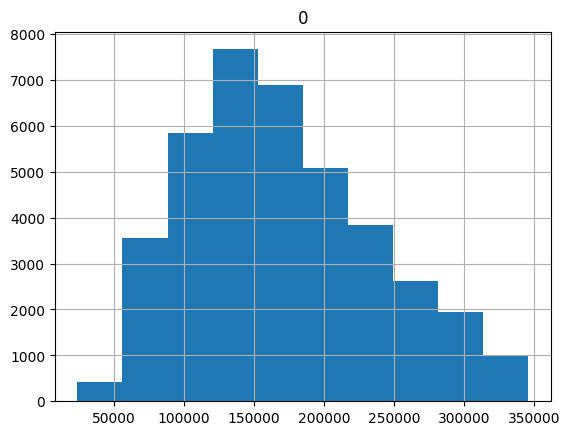

In [ ]:
import pandas as pd
pd.DataFrame(dataset["validation"]["input_length"]).hist()

In [ ]:
pd.DataFrame(dataset["validation"]["input_length"]).describe()

NameError: name 'pd' is not defined

In [ ]:
def filter_by_length(batch):
    return batch["input_length"] <= 180864

In [ ]:
dataset = dataset.filter(filter_by_length, num_proc=64)

Loading cached processed dataset at /workspaces/HuggingFace-Audio-Course/bengaliai-speech_huggingface/train/cache-7beae8d9fa1655fb_*_of_00064.arrow
Loading cached processed dataset at /workspaces/HuggingFace-Audio-Course/bengaliai-speech_huggingface/validation/cache-db7c401f0d345f3e_*_of_00064.arrow


In [ ]:
dataset["validation"] = dataset["validation"].select(pd.Series(list(range(len(dataset["validation"])))).sample(num_val_samples).values)

In [ ]:
# import torch
# def filter_invalid(batch):
#     return torch.tensor(batch["input_values"]).isfinite().all()

In [ ]:
# common_voice_train.filter(filter_invalid, num_proc=32)

In [ ]:
# import re
# chars_to_remove_regex = '[\,\?\.\!\-\;\:\"\“\%\‘\”\�\'\‚\/]'

# def remove_special_characters(batch):
#     batch["sentence"] = re.sub(chars_to_remove_regex, '', batch["sentence"]).lower()
#     return batch

In [ ]:
# common_voice_train = common_voice_train.map(remove_special_characters)
# common_voice_test = common_voice_test.map(remove_special_characters)

In [ ]:
# def extract_all_chars(batch):
#   all_text = " ".join(batch["sentence"])
#   vocab = list(set(all_text))
#   return {"vocab": [vocab], "all_text": [all_text]}

In [ ]:
# vocab_train = common_voice_train.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=common_voice_train.column_names)
# vocab_test = common_voice_test.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=common_voice_test.column_names)

In [ ]:
# def prepare_dataset(batch):
#     audio = batch["audio"]

#     # batched output is "un-batched"
#     batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
#     batch["input_length"] = len(batch["input_values"])

#     batch["labels"] = processor(text=batch["sentence"]).input_ids
#     return batch


In [ ]:
# common_voice_train = common_voice_train.map(prepare_dataset, remove_columns=common_voice_train.column_names)
# common_voice_test = common_voice_test.map(prepare_dataset, remove_columns=common_voice_test.column_names)

In [ ]:
# import pandas as pd
# import os
# from torch.utils.data import Dataset
# from datasets import Audio

# class AudioDataset(Dataset):
#     def __init__(self, labels_df: pd.DataFrame, data_path: str, processor):
#         self.labels_df = labels_df
#         self.data_path = data_path
#         self.processor = processor
#     def __len__(self):
#         return len(self.labels_df)
#     def __getitem__(self,idx):
#         row = self.labels_df.iloc[idx]
#         path = os.path.join(self.data_path, row["id"]+".mp3")
#         sentence = row["sentence"]
#         with open(path, "rb") as f:
#             speech = f.read()
#             audio = Audio(sampling_rate=processor.feature_extractor.sampling_rate).decode_example({"path": path, "bytes": speech})

#         example = processor(audio=audio["array"], sampling_rate=processor.feature_extractor.sampling_rate, text=sentence, return_tensors="pt")
#         example["input_values"] = example["input_values"][0]
#         example["labels"] = example["labels"][0]
#         example["input_length"] = len(audio["array"]) // processor.feature_extractor.sampling_rate
#         # speech, sr = librosa.load(path, sr=processor.feature_extractor.sampling_rate) 
# #         print(speech.shape)
#         return example

In [ ]:
# from datasets import DatasetDict
# labels_df = pd.read_csv("bengaliai-speech/train.csv")

In [ ]:
# from sklearn.model_selection import train_test_split
# train_df, val_df = train_test_split(labels_df, test_size=0.1, random_state=42)

In [ ]:
# common_voice = DatasetDict()
# train_dataset= AudioDataset(train_df, data_path="bengaliai-speech/train_mp3s", processor=processor)
# test_dataset = AudioDataset(val_df, data_path="bengaliai-speech/train_mp3s", processor=processor)

In [ ]:
# common_voice = DatasetDict({"train":train_dataset,"test": test_dataset})

In [ ]:
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            return_tensors="pt",
        )

        labels_batch = self.processor.pad(
            labels=label_features,
            padding=self.padding,
            return_tensors="pt",
        )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch


In [ ]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

In [ ]:
from evaluate import load

wer_metric = load("wer")

In [ ]:
import numpy as np
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}


In [ ]:
from transformers import Wav2Vec2ForCTC

model = Wav2Vec2ForCTC.from_pretrained(
    model_name,
    attention_dropout=0.0,
    hidden_dropout=0.0,
    feat_proj_dropout=0.0,
    layerdrop=0.0,
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
    vocab_size=len(processor.tokenizer),
    ignore_mismatched_sizes=True,
)

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/mms-1b-all and are newly initialized because the shapes did not match:
- lm_head.bias: found shape torch.Size([154]) in the checkpoint and torch.Size([136]) in the model instantiated
- lm_head.weight: found shape torch.Size([154, 1280]) in the checkpoint and torch.Size([136, 1280]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.init_adapter_layers()
model.freeze_base_model()

adapter_weights = model._get_adapters()
for param in adapter_weights.values():
    param.requires_grad = True


In [ ]:
import os
import tempfile
import shutil
import json
import kaggle
from pathlib import Path
from transformers import TrainerCallback
from transformers.trainer_callback import TrainerControl, TrainerState
from transformers.training_args import TrainingArguments

class KaggleUploader(TrainerCallback):
    def __init__(self, dataset_path: str, id: str, title: str, isPrivate: bool):
        self.api = kaggle.KaggleApi()
        self.api.authenticate()
        self.dataset_path = dataset_path
        self.meta_data = dict(
            id=id,
            title=title,
            isPrivate=isPrivate,
            licenses=[dict(name="other")]
        )
        self.previous_best = None

    def on_save(self, args: TrainingArguments, state: TrainerState, control: TrainerControl, **kwargs):
        best_model_checkpoint = str(Path(state.best_model_checkpoint).name)
        print(state.best_model_checkpoint)
        if best_model_checkpoint != self.previous_best:
            self.upload_dataset_to_kaggle(self.dataset_path, best_model_checkpoint)
            self.previous_best = best_model_checkpoint
        
        return super().on_evaluate(args, state, control, **kwargs)
    
    def upload_dataset_to_kaggle(self, dataset_path, checkpoint_to_save: str):
        # latest_checkpoint = find_latest_checkpoint(dataset_path)
        checkpoint = os.path.join(dataset_path, checkpoint_to_save)

        version_notes = checkpoint_to_save
        # The checkpoint has multiple files that we don't need.
        # We only need the pytorch_model.bin file, config.json and generation_config.json
        # Copy these files to a temporary folder
        with tempfile.TemporaryDirectory() as temp_dir:
            # create a directory inside named "model"
            temp_model_dir = os.path.join(temp_dir, "model")
            os.mkdir(temp_model_dir)
            # copy the files
            for file in ["pytorch_model.bin", "config.json"]:
                shutil.copy(os.path.join(checkpoint, file), temp_model_dir)

            # create dataset-metadata.json inside the temporary directory
            with open(os.path.join(temp_model_dir, "dataset-metadata.json"), "w") as f:
                json.dump(self.meta_data, f)

            self.api.dataset_create_version(temp_model_dir, version_notes=version_notes, dir_mode="zip")

In [ ]:
kaggle_uploader = KaggleUploader("/workspaces/HuggingFace-Audio-Course/mms-1b-all-bengali",
                                 id="kurokabe/mms-1b-model",
                                 title="MMS 1B bengali", 
                                 isPrivate=True)

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir=repo_name,
  group_by_length=True,
  length_column_name="input_length",
  per_device_train_batch_size=32,
  per_device_eval_batch_size=32,
  # gradient_accumulation_steps=4,
  evaluation_strategy="steps",
  num_train_epochs=2,
  # max_steps=500,
  gradient_checkpointing=True,
  fp16=True,
  save_steps=250,
  eval_steps=250,
  logging_steps=100,
  learning_rate=5e-6,
  warmup_steps=100,
  save_total_limit=2,
  # push_to_hub=True,
  metric_for_best_model="wer",
  greater_is_better=False,
  load_best_model_at_end=True,
  # debug="underflow_overflow"
  # dataloader_num_workers=64,
)


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=processor.feature_extractor,
    callbacks=[kaggle_uploader]
)

In [ ]:
trainer.train(resume_from_checkpoint="/workspaces/HuggingFace-Audio-Course/mms-1b-all-bengali/checkpoint-3500")

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Wer
2250,2.331800,1.384291,0.781540
2500,2.187000,1.229206,0.741407
2750,2.038600,1.051850,0.689443
3000,1.884800,0.912545,0.645039
3250,1.877500,0.916694,0.632391
3500,1.901400,0.880957,0.621890
3750,1.882500,0.917044,0.625393
4000,1.933100,0.918206,0.624537
4250,1.951500,0.918206,0.624537
4500,1.934800,0.918206,0.624537


mms-1b-all-bengali/checkpoint-2250
Starting upload for file pytorch_model.bin


100%|██████████| 3.59G/3.59G [01:38<00:00, 39.0MB/s]


Upload successful: pytorch_model.bin (4GB)
Starting upload for file config.json


100%|██████████| 2.00k/2.00k [00:00<00:00, 3.20kB/s]


Upload successful: config.json (2KB)
mms-1b-all-bengali/checkpoint-2500
Starting upload for file pytorch_model.bin


100%|██████████| 3.59G/3.59G [01:25<00:00, 45.4MB/s]


Upload successful: pytorch_model.bin (4GB)
Starting upload for file config.json


100%|██████████| 2.00k/2.00k [00:00<00:00, 3.29kB/s]


Upload successful: config.json (2KB)
mms-1b-all-bengali/checkpoint-2750
Starting upload for file pytorch_model.bin


100%|██████████| 3.59G/3.59G [01:38<00:00, 39.3MB/s]


Upload successful: pytorch_model.bin (4GB)
Starting upload for file config.json


100%|██████████| 2.00k/2.00k [00:00<00:00, 3.24kB/s]


Upload successful: config.json (2KB)
mms-1b-all-bengali/checkpoint-3000
Starting upload for file pytorch_model.bin


100%|██████████| 3.59G/3.59G [01:35<00:00, 40.3MB/s]


Upload successful: pytorch_model.bin (4GB)
Starting upload for file config.json


100%|██████████| 2.00k/2.00k [00:00<00:00, 3.50kB/s]


Upload successful: config.json (2KB)
mms-1b-all-bengali/checkpoint-3250
Starting upload for file pytorch_model.bin


100%|██████████| 3.59G/3.59G [01:36<00:00, 39.8MB/s]


Upload successful: pytorch_model.bin (4GB)
Starting upload for file config.json


100%|██████████| 2.00k/2.00k [00:00<00:00, 2.11kB/s]


Upload successful: config.json (2KB)
mms-1b-all-bengali/checkpoint-3500
Starting upload for file pytorch_model.bin


100%|██████████| 3.59G/3.59G [01:23<00:00, 46.4MB/s]


Upload successful: pytorch_model.bin (4GB)
Starting upload for file config.json


100%|██████████| 2.00k/2.00k [00:01<00:00, 1.86kB/s]


Upload successful: config.json (2KB)
mms-1b-all-bengali/checkpoint-3500
mms-1b-all-bengali/checkpoint-3500
mms-1b-all-bengali/checkpoint-3500
mms-1b-all-bengali/checkpoint-3500


In [126]:
test_input = torch.tensor(combined_val[0]["input_values"]).unsqueeze(0)
# cast to torch.float16
test_input = test_input.to("cuda")
logits = model(test_input).logits
pred_ids = torch.argmax(logits, dim=-1)[0]
print("Prediction:", processor.tokenizer.decode(pred_ids, skip_special_tokens=True))

Prediction: তাই যুদ্ধের শুরুতেকেই পাকিস্তানী বাহিনী বাছাই করে করে বুদ্ধিজীবিদের হত্তা করতে থাকে।


In [55]:
# from safetensors.torch import save_file as safe_save_file
# from transformers.models.wav2vec2.modeling_wav2vec2 import WAV2VEC2_ADAPTER_SAFE_FILE
# import os

# adapter_file = WAV2VEC2_ADAPTER_SAFE_FILE.format(target_lang)
# adapter_file = os.path.join(training_args.output_dir, adapter_file)

# safe_save_file(model._get_adapters(), adapter_file, metadata={"format": "pt"})

In [37]:
# trainer.push_to_hub()

Upload file pytorch_model.bin:   0%|          | 1.00/3.59G [00:00<?, ?B/s]

Upload file runs/Aug01_15-37-33_772b1c8fe2c9/events.out.tfevents.1690904260.772b1c8fe2c9:   0%|          | 1.0…

Upload file runs/Aug01_15-26-34_772b1c8fe2c9/events.out.tfevents.1690903598.772b1c8fe2c9:   0%|          | 1.0…

Upload file runs/Aug01_15-28-33_772b1c8fe2c9/events.out.tfevents.1690903717.772b1c8fe2c9:   0%|          | 1.0…

Upload file runs/Aug01_15-27-39_772b1c8fe2c9/events.out.tfevents.1690903662.772b1c8fe2c9:   0%|          | 1.0…

Upload file runs/Aug01_15-43-36_772b1c8fe2c9/events.out.tfevents.1690904686.772b1c8fe2c9:   0%|          | 1.0…

Upload file runs/Aug01_15-25-32_772b1c8fe2c9/events.out.tfevents.1690903536.772b1c8fe2c9:   0%|          | 1.0…

Upload file runs/Aug01_15-30-58_772b1c8fe2c9/events.out.tfevents.1690903867.772b1c8fe2c9:   0%|          | 1.0…

Upload file training_args.bin:   0%|          | 1.00/3.87k [00:00<?, ?B/s]

To https://huggingface.co/Kurokabe/mms-1b-all-bengali
   2b7c63c..a06b654  main -> main

To https://huggingface.co/Kurokabe/mms-1b-all-bengali
   a06b654..ac833ad  main -> main



'https://huggingface.co/Kurokabe/mms-1b-all-bengali/commit/a06b654b114e0ebff3d896de3f3a1b0067fded11'